In [1]:
import os
os.chdir("/data/yosef2/users/chenling/HarmonizationSCANVI")
import sys
sys.path.append("/data/yosef2/users/chenling/HarmonizationSCANVI")

In [2]:
from scvi.dataset import GeneExpressionDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.inference.posterior import get_IS_bayes_factors
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import kendalltau
from scvi.models.scanvi import SCANVI
import pickle
from copy import deepcopy
from sklearn.decomposition import PCA

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.chdir('/data/yosef2/users/chenling/HarmonizationSCANVI')

import sys


In [3]:
save_path = "../symsim_scVI/symsim_result/DE/"

label_array = pd.read_csv(os.path.join(save_path, "DE.cell_meta.csv"),
                          sep=",", index_col=0)["pop"].values

batch_array = pd.read_csv(os.path.join(save_path, "DE.batchid.csv"),
                          sep=",", index_col=0)["x"].values
# Renumerate the batches to be between 0 and N-batches
batch_array -= 1
batch_array = batch_array[:, np.newaxis]

count_matrix = pd.read_csv(os.path.join(save_path, "DE.obsv.2.csv"),
                           sep=",", index_col=0).T

gene_names = np.array(count_matrix.columns, dtype=str)

dataset1 = GeneExpressionDataset(*GeneExpressionDataset.get_attributes_from_matrix(
    count_matrix.values, labels=label_array,batch_indices=batch_array),
    gene_names=gene_names, cell_types=np.unique(label_array))

dataset1.update_cells(batch_array.ravel()==0)

count_matrix = pd.read_csv(os.path.join(save_path, "DE.obsv.4.csv"),
                           sep=",", index_col=0).T

dataset2 = GeneExpressionDataset(*GeneExpressionDataset.get_attributes_from_matrix(
    count_matrix.values, labels=label_array,batch_indices=batch_array),
    gene_names=gene_names, cell_types=np.unique(label_array))

dataset2.update_cells(batch_array.ravel()==1)

gene_dataset = GeneExpressionDataset.concat_datasets(dataset1, dataset2)
# gene_dataset.subsample_genes(500)

labels = [int(gene_dataset.cell_types[i])-1 for i in gene_dataset.labels.ravel()]
gene_dataset.labels = np.asarray(labels).reshape(len(labels),1)
gene_dataset.cell_types = dataset2.cell_types

In [10]:
gene_dataset.gene_names = gene_dataset.gene_names.astype('int')
dataset1.gene_names = dataset1.gene_names.astype('int')
dataset2.gene_names = dataset2.gene_names.astype('int')


In [11]:
from scvi.harmonization.utils_chenling import SubsetGenes
plotname = 'sim'

In [12]:
dataset1, dataset2, gene_dataset = SubsetGenes(dataset1, dataset2, gene_dataset, plotname)

Downsampling from 5000 to 1043 genes
Downsampling from 9888 to 9888 cells


/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Downsampling from 5000 to 1043 genes
Downsampling from 10112 to 10112 cells
Downsampling from 5000 to 1043 genes
Downsampling from 20000 to 20000 cells


In [13]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, reconstruction_loss="zinb", n_latent=10, 
          dispersion='gene')
trainer = UnsupervisedTrainer(vae,gene_dataset,use_cuda=True)

n_epochs = 250
trainer.train(n_epochs=n_epochs)
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()

training: 100%|██████████| 250/250 [10:40<00:00,  2.53s/it]


In [22]:
full.differential_expression_stats(M_sampling=100,force_batch=0)

(array([[[2.46971249e-05, 1.37878174e-04, 3.34506010e-04, ...,
          2.03105714e-03, 4.05979721e-04, 3.67829962e-05],
         [1.26168365e-04, 1.75875830e-04, 4.20754775e-04, ...,
          3.54081206e-03, 7.69366336e-04, 8.53895326e-05],
         [3.28123861e-05, 7.36337272e-04, 4.42278288e-05, ...,
          9.31190909e-04, 2.80993961e-04, 3.15230864e-05],
         ...,
         [6.36814366e-05, 3.66798427e-04, 1.03932616e-04, ...,
          1.43849256e-03, 1.46142920e-04, 4.03456906e-05],
         [6.96564239e-05, 3.66232620e-04, 1.45502330e-04, ...,
          2.58733565e-03, 6.08721050e-04, 2.24508083e-04],
         [3.31355113e-05, 1.58221636e-04, 9.82224665e-05, ...,
          1.50133832e-03, 1.15914852e-04, 5.76201091e-05]],
 
        [[2.48742199e-05, 1.31879293e-04, 3.51606141e-04, ...,
          1.99104054e-03, 3.97183700e-04, 3.61572456e-05],
         [1.19227734e-04, 1.70994041e-04, 4.52489330e-04, ...,
          3.61756771e-03, 6.93062029e-04, 8.57748964e-05],
       

In [14]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import numpy as np
from umap import UMAP


In [15]:
latent_u = UMAP(spread=2).fit_transform(latent)

In [16]:
labels = gene_dataset.labels.ravel()

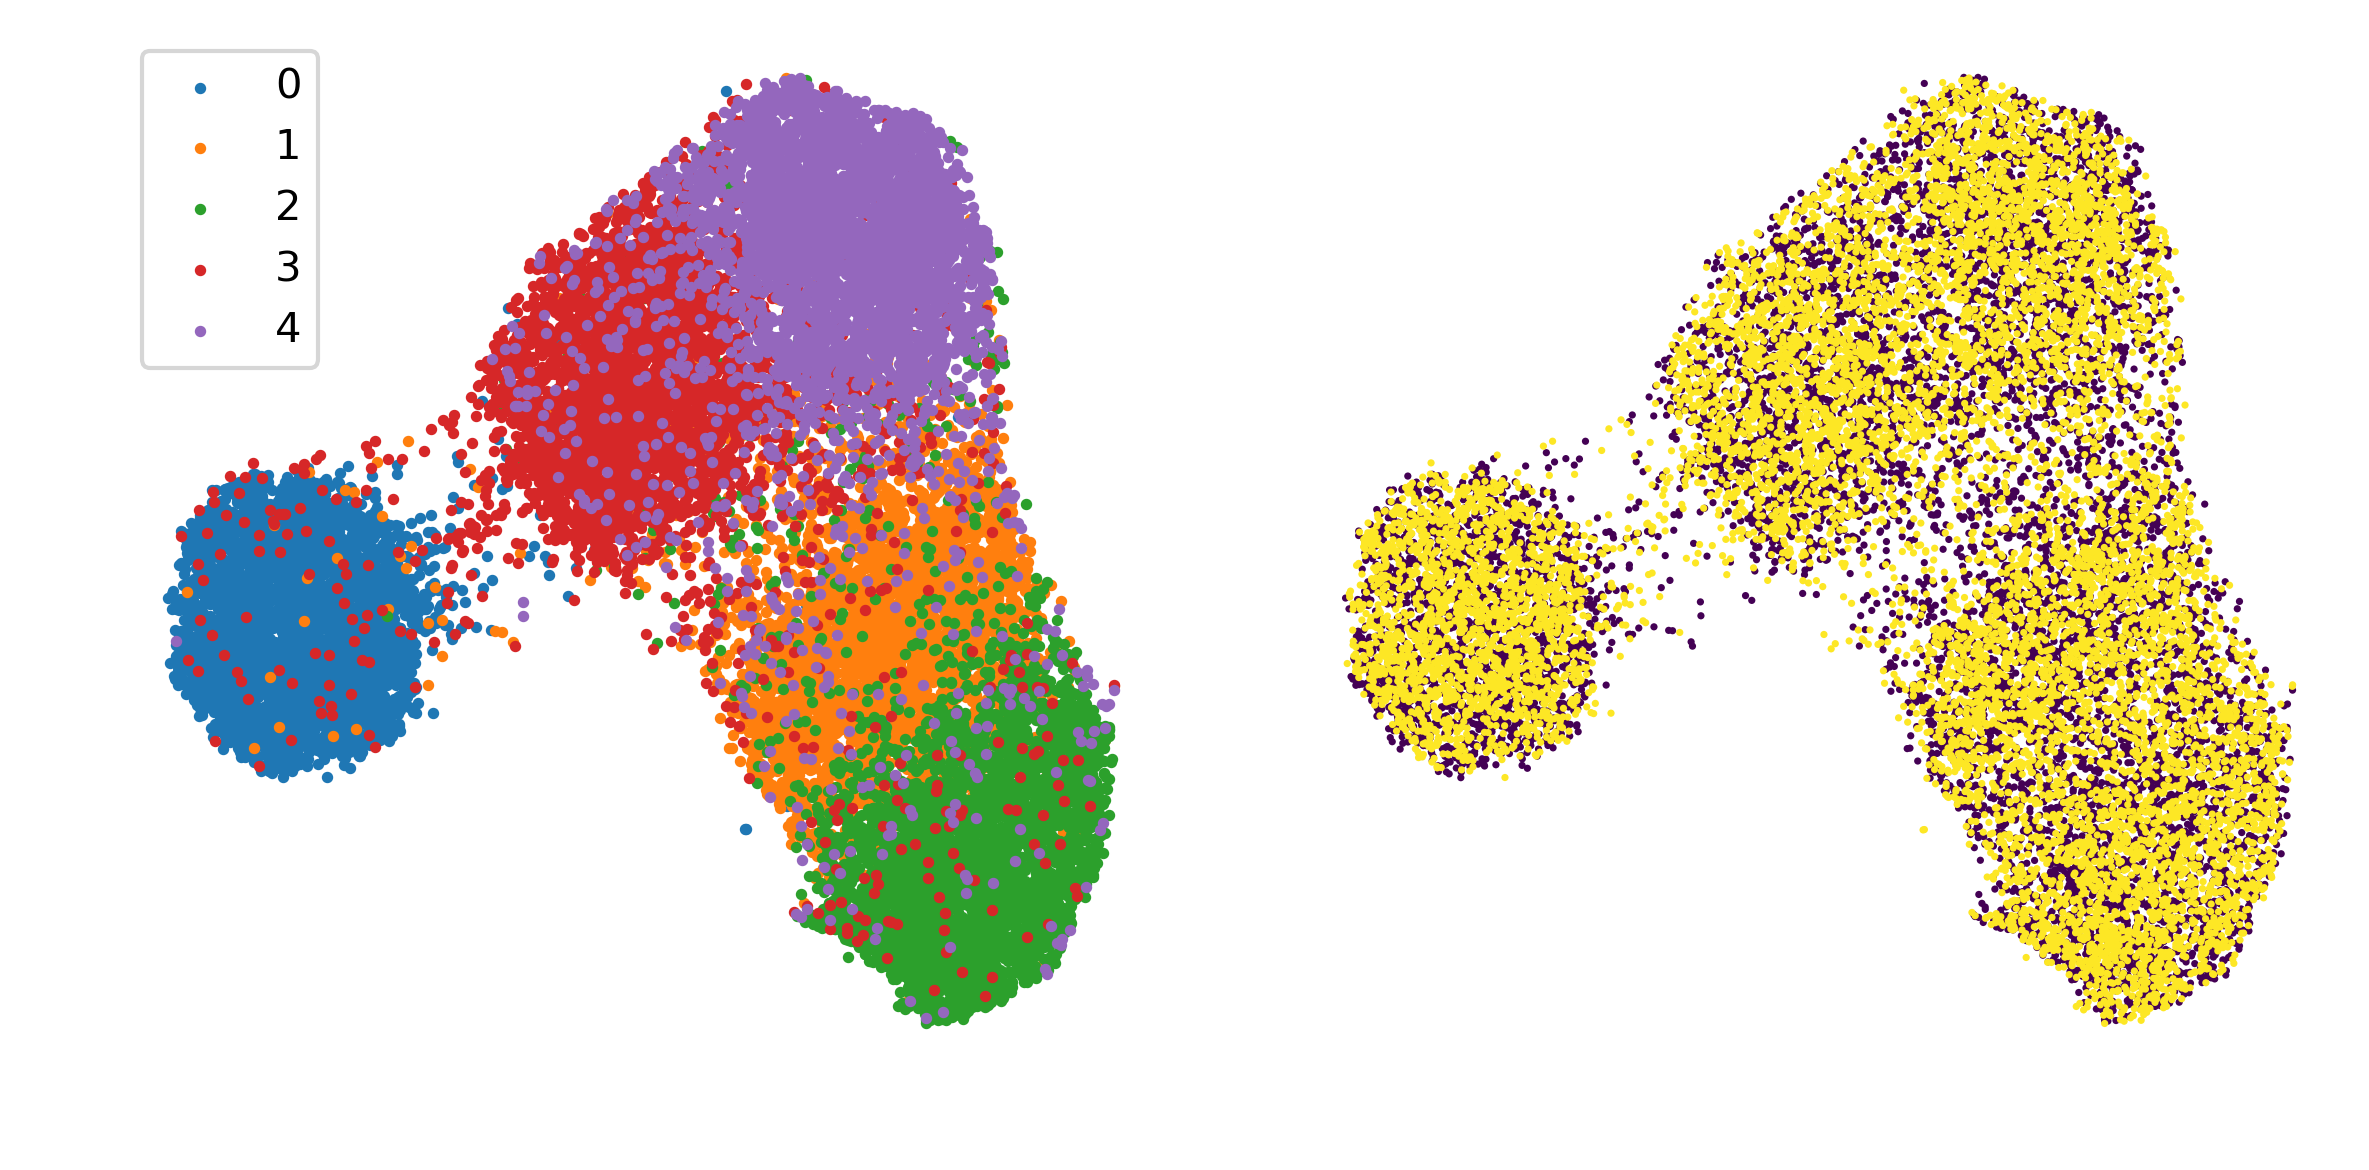

In [20]:
plt.figure(figsize=(8, 4), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=3)

plt.axis('off')
plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=3)
plt.axis("off")
plt.tight_layout()
plt.savefig('SymSim.UMAP.pdf')

In [18]:
from sklearn.preprocessing import normalize

In [ ]:
X = np.log(1 + gene_dataset.X)
norm_X = normalize(X,norm='l1')
latent = PCA(n_components=10).fit_transform(norm_X)

In [ ]:
latent_pc = UMAP(spread=2).fit_transform(latent)
plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_pc[labels == k, 0], latent_pc[labels == k, 1], label=k,s=10)

plt.axis('off')
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_pc[:, 0], latent_pc[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
np.savetxt( '/data/yosef2/users/chenling/symsim_scVI/symsim_result/DE/DE.obsv.csv', gene_dataset.X, delimiter=',',)

In [ ]:
np.savetxt('/data/yosef2/users/chenling/symsim_scVI/symsim_result/DE/DE.obsv.labels.csv', gene_dataset.labels.ravel())

In [ ]:
np.savetxt('/data/yosef2/users/chenling/symsim_scVI/symsim_result/DE/DE.obsv.batch.csv', gene_dataset.batch_indices.ravel())